# Image deblurring (Part 2)
This article is a follow up to my last article [Image debluring (Part 1)](https://miller-blog.com/?p=905). There I wrote about the specific problem of image deblurring. The problem is to find the original image, which is convolved with a known point spread function. This can be solved with an interactive optimization procedure. My intention to write about this problem, was to learn about scientific optimization in general.  
Everyone who is using Python should consider [NumPy](http://www.numpy.org/) (in combination with [SciPy](https://www.scipy.org/)) as the number one library for this task. It is easy to use, stable and many libraries are building on top of it. A feature I am missing is [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). It is tedious and error prone to calculate gradients by hand, but they are needed for gradient descent based optimization algorithms. That is why I have tried out [TensorFlow](https://www.tensorflow.org/) in the first article.  
TensorFlow is a numerical library. It has automatic differentiation and modern optimization procedures built-in. Another big advantage is, that you can run the calculations on a GPU and even on a distributed cluster. TensorFlow is developed for deep learning problems. That is where the disadvantages come from if you want to do general scientific optimization. Because the computation is done lazy, debugging is relatively hard. In addition 64 bit floating point numbers, which are still often used outside of deep learning, are not completely supported.  
In this article I want to test a different library. [Autograd](https://github.com/HIPS/autograd) is an extension of NumPy. It can calculate the gradient of a function which consist of NumPy and SciPy functions. Unfortunately currently not all functions are support. Especially SciPy functions are often missing. Autograd is still in active development, so this problem might be less relevant in the future. The advantages of Autograd are that it is easy to use, debug and has all advantages of NumPy, like proper 64 bit support.

As already mentioned Autograd is a plugin replacement to NumPy and SciPy. Instead of directly importing numpy we import it from autograd.numpy. Therefore the Autograd adjusted NumPy functions are used.  
In the same way to the first article we load the astronaut image from skimage. Then we create the point spread function, with which the image is convolved. The point spread function is a Gaussian with different standard deviations in x- and y-direction.

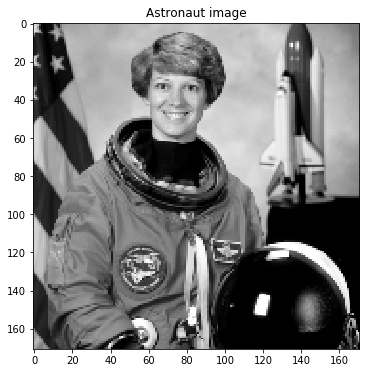

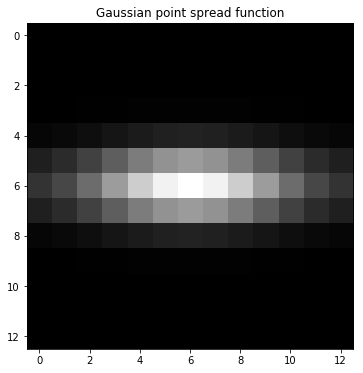

In [1]:
%matplotlib inline
import autograd.numpy as np
import scipy.ndimage.filters as fi
import matplotlib.pyplot as plt
from skimage import color, data
from skimage.transform import rescale

astro_org = rescale(color.rgb2gray(data.astronaut()), 1.0/3.0, mode='constant')

plt.figure(figsize=(6, 6))
plt.gray()
plt.imshow(astro_org)
plt.title('Astronaut image')
plt.show()

def gaussian(kernlen, nsig_x, nsig_y):
    inp = np.zeros((kernlen, kernlen))
    inp[kernlen//2, kernlen//2] = 1
    kern = fi.gaussian_filter(inp, (nsig_x, nsig_y))
    scaled_kern = kern / np.sum(kern)
    return np.array(scaled_kern)

psf = gaussian(kernlen=13, nsig_x=1, nsig_y=3)

plt.figure(figsize=(6, 6))
plt.imshow(psf)
plt.title('Gaussian point spread function');

The original astronaut image is convolved with the point spread function. Similar to using numpy from autograd, we use the convolve function from autograd.scipy.signal instead of scipy.signal. I intended to use the convolved2d function from scipy.signal, however Autograd does not implement this function.

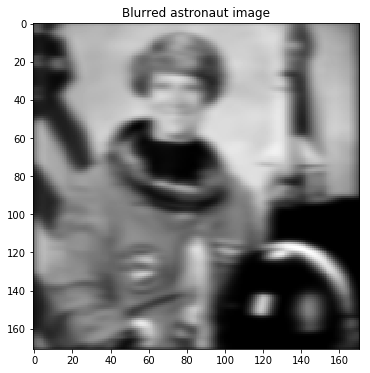

In [2]:
from autograd.scipy.signal import convolve

def convolve2d(image, psf):
    half_x = (psf.shape[0] - 1) // 2
    half_y = (psf.shape[1] - 1) // 2
    return convolve(image, psf, mode='full')[half_x:-half_x,half_y:-half_y]

astro_blur = convolve2d(astro_org, psf)

plt.figure(figsize=(6, 6))
plt.imshow(astro_blur)
plt.title('Blurred astronaut image');

The deconvolution is implemented as an optimization problem. The loss is the deviation of the given image (original convolved astronaut image) and the estimated convolved image. You could implement it completely in NumPy, but manual differentiating the loss function is tedious and error prone. Autograd has an automatic differentiation procedure. We use the grad function to differentiate the objective. The resulting gradient is used during the optimization. We use the standard SciPy procedure minimize for the optimization. SciPy has implemented a large number of optimization algorithms. Here we use the Newton Conjugate algorithm.

In [3]:
from scipy.optimize import minimize
from autograd import grad

def l2_loss(t):
    return np.sum(t ** 2) / 2

def deconvolve(image, psf, learning_rate=5e-1, mu=0.2):
    loss_history = []
    image_shape = image.shape

    def objective(params):
        input = np.reshape(params, image_shape)
        output = convolve2d(input, psf)
        output_loss = np.sqrt(l2_loss(output - image))
        regularization = np.sqrt(l2_loss(input[:-1, :] - input[1:, :]) + l2_loss(input[:, :-1] - input[:, 1:]))
        loss = output_loss + mu * regularization
        return loss

    objective_with_grad = grad(objective)
    res = minimize(objective, np.random.randn(np.prod(image_shape)) / 10.0, jac=objective_with_grad, method='Newton-CG')

    return np.reshape(res['x'], image_shape)

astro_deconv = deconvolve(astro_blur, psf)

Let's plot the original, the blurred and the deconvolved image. The deconvolved image (right) looks exactly the same as the one from the first article. This shows, that the Autograd implementation in fact works as intended.

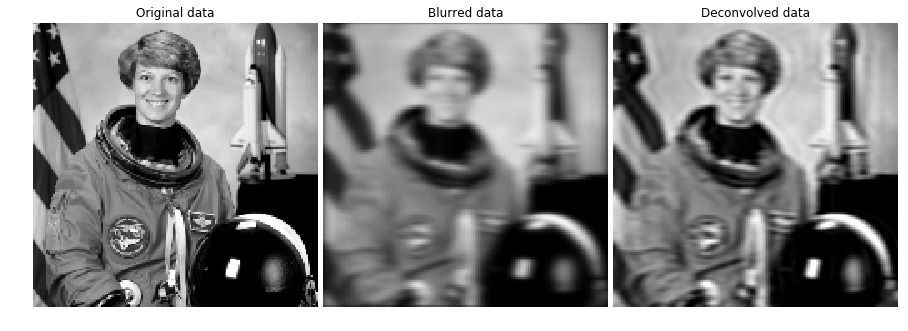

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

for a in ax:
    a.axis('off')

ax[0].imshow(astro_org, vmin=astro_org.min(), vmax=astro_org.max())
ax[0].set_title('Original data')

ax[1].imshow(astro_blur, vmin=astro_org.min(), vmax=astro_org.max())
ax[1].set_title('Blurred data')

ax[2].imshow(astro_deconv, vmin=astro_org.min(), vmax=astro_org.max())
ax[2].set_title('Deconvolved data')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)

This article showed you how to perform scientific optimization on the example of image deconvolution. For this the library Autograd is used. It is based directly on NumPy und SciPy. In the last article it was shown how to solve this problem with TensorFlow instead of Autograd. With Autograd we are able to reproduce these results.  
Autograd has some advantages over TensorFlow, like better 64 bit support, but not all NumPy and SciPy functions are implemented.  This article showed, that Autograd is a viable alternative for implementing scientific optimization problems, but there are still more libraries, which are able to automatic differentiate functions. One noticeable is [PyTorch](http://pytorch.org/). Maybe I will look into PyTorch in another article. 